In [ ]:
%load_ext pycodestyle_magic

In [1]:
# %%pycodestyle
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as shc
import matplotlib.patches as mpatches
from sklearn.cluster import AgglomerativeClustering
from collections import namedtuple
from numpy import nan
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score


In [2]:
# %%pycodestyle

new_metadata = pd.read_csv(
    "../data/metadata/CMS001_CMS002_MergedAnnotations.csv",
    header=0,
)

species_id = new_metadata[[
    "czbiohub-mosquito_sequences_id",
    "visual_genus",
    "visual_species",
    "sourmash_species",
    "sourmash_genus"
]]

species_id.rename(
    columns={
        'compute_species': 'sourmash_species',
        'compute_genus': 'sourmash_genus',
        'czbiohub-mosquito_sequences_id': ''
    },
    inplace=True
)
species_id.set_index("", inplace=True)


/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [3]:
# %%pycodestyle

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def clean_data(dd_tsv, tailing, metadata):
    '''
    remove trailing suffix and replace column name spaces with underscores
    '''

    dd_tsv.columns = dd_tsv.columns.str.replace(" ", "_")

    # Add prefix columns and size
    dd_tsv["Sample_1"] = dd_tsv.apply(
        lambda row: row["Sample_1"].split(tailing)[0],
        axis=1
    )
    dd_tsv["Sample_2"] = dd_tsv.apply(
        lambda row: row["Sample_2"].split(tailing)[0],
        axis=1
    )

    # re-organize columns
    dd_tsv = dd_tsv[
        [
            "Sample_1",
            "Sample_2",
            "Matches",
            "Mismatches",
            "Jaccard_Index",
            "Mash-like_distance",
            "SNPs",
            "SNP_distance"
        ]
    ]
    return dd_tsv


def create_pivot(df, values="SNP_distance", diagonal=0, remove_water=True):
    ''' create pivot tables with sample 1 and sample 2 correlations'''

    dd_tsv_pivot = df.pivot(
        columns="Sample_1",
        index="Sample_2",
        values=values
    )
    dd_tsv_pivot = dd_tsv_pivot.loc[dd_tsv_pivot.columns, :]
    np.fill_diagonal(dd_tsv_pivot.values, diagonal)
    dd_tsv_pivot = dd_tsv_pivot.fillna(0) + dd_tsv_pivot.T.fillna(0) - np.diag(dd_tsv_pivot.values.diagonal())

    # remove waters from pivot table
    if remove_water:
        t_raw_piv_no_waters = dd_tsv_pivot[~(dd_tsv_pivot.index.str.contains("ater"))]
        t_raw_piv_no_waters_col = t_raw_piv_no_waters.drop(
            columns=t_raw_piv_no_waters.columns[
                t_raw_piv_no_waters.columns.str.contains("ater")
            ]
        )
    
        return t_raw_piv_no_waters_col
    
    else:
        return dd_tsv_pivot


def add_metadata_to_pivot(df, metadata_fields, metadata):
    """join metadata onto pivot table for axis labeling"""

    dd_tsv_pivot_w_labels = pd.merge(
        df.reset_index(),
        metadata[metadata_fields],
        how='left',
        left_on="Sample_1",
        right_index=True,
    ).reset_index().set_index(
        ["Sample_1"] + metadata_fields
    ).drop(["index"], axis=1)

    return dd_tsv_pivot_w_labels


def get_linkage(pivot_df):
    '''clustering linkage'''

    cdist = scipy.spatial.distance.squareform(pivot_df)
    return scipy.cluster.hierarchy.linkage(cdist, method="ward")


def get_cluster_map(pivot_df, linkage, num_clusters, extra=True):
    """cluster distance matrix and re-assign species as cluster species mode"""

    clusters = fcluster(linkage, num_clusters, criterion='maxclust')
    cluster_map = pd.DataFrame()

    if extra:
        cluster_map['visual_genus'] = pivot_df.index.get_level_values(1)
        cluster_map['visual_species'] = pivot_df.index.get_level_values(2)

    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)

    cluster_chunks = []
    for clust in cluster_map.cluster.unique():
        subset = cluster_map[cluster_map.cluster == clust]
        species_mode = subset.visual_species.mode()[0]
        genus_mode = subset[
            subset["visual_species"] == species_mode
        ].visual_genus.values[0]
        subset["ska_species"] = species_mode
        subset["ska_genus"] = genus_mode
        cluster_chunks.append(subset)

    cluster_map_w_ska = pd.concat(cluster_chunks)
    return cluster_map_w_ska


def join_on_ska_labels(raw_df, metadata, tailing, k, values="SNP_distance", diagonal=0):
    '''create pivot from distance matrix with old and new species labels'''

    df_cleaned = clean_data(
        raw_df,
        metadata=metadata,
        tailing=tailing
    )

    dd_pivot = create_pivot(
        df_cleaned,
        values=values,
        diagonal=diagonal
    )

    metadata_fields = [
        "visual_genus",
        "visual_species",
    ]

    dd_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot,
        metadata_fields,
        metadata=metadata
    )

    linkage = get_linkage(dd_pivot)

    cluster_map = get_cluster_map(
        dd_pivot_w_labels,
        linkage,
        k,
        extra=True
    )

    ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

    final_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot,
        ska_metadata_fields,
        metadata=cluster_map
    )

    return final_pivot_w_labels, cluster_map, linkage


def wrap_clustermap_and_mismatches(
    raw_df,
    metadata,
    tailing,
    k=10,
    figsize=(35, 35),
    values="SNP_distance",
    diagonal=0
):
    '''create clustermap with new and old species assigned labels'''

    pivot_w_labels, cluster_map, linkage = join_on_ska_labels(
        raw_df, 
        metadata, 
        tailing, 
        k, 
        values=values, 
        diagonal=0
    )
    
    c, leg, cbar = correlation_matrix(
        pivot_w_labels,
        linkage,
        cluster_map,
        figsize=figsize
    )

    return c, leg, cbar, pivot_w_labels

def hierarchical_clustering(
    raw_df,
    metadata,
    tailing,
    k,
    values="SNP_distance",
    diagonal=0
):
    pivot_df, cluster_map, linkage = join_on_ska_labels(
        raw_df, 
        metadata, 
        tailing, 
        k, 
        values=values,
        diagonal=diagonal
    )
    cdist = scipy.spatial.distance.squareform(pivot_df)
    Z = shc.linkage(cdist, method="ward")
    fig = plt.figure(figsize=(25, 10))

    dn = shc.dendrogram(
        Z,
        leaf_font_size=8,
        labels=pivot_df.index.get_level_values(4),
        color_threshold=0.008
    )

    return dn


def get_silhouette_score(
    raw_df,
    metadata,
    tailing,
    k,
    values="SNP_distance",
    diagonal=0,
    correlation=False
):
    '''use silhouette metric to see how compact and distinct clusters are '''
    
    pivot_df, cluster_map, linkage = join_on_ska_labels(
        raw_df, 
        metadata, 
        tailing, 
        k, 
        values=values,
        diagonal=diagonal
    )
    cdist = scipy.spatial.distance.squareform(pivot_df)
    linkage = scipy.cluster.hierarchy.linkage(cdist, method="ward")
    clusters = fcluster(linkage, k, criterion='maxclust')

    cluster_map = pd.DataFrame()

    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)

    return silhouette_score(
        pivot_df,
        metric="precomputed",
        labels=cluster_map["cluster"]
    )


def correlation_matrix(
    pivot_w_labels,
    linkage,
    cluster_map,
    figsize=(35, 35)
):
    '''correlatian matrix comparing visual and ska species assignment'''

    legend_labeling = {
         'Culex pipiens': "#4c72a5",
         'Culex erythrothorax': "#48a365",
         'Culex quinquefasciatus': "#77bedb",
         'Culex tarsalis': "#90ce9b",

         'Aedes aegypti': "#ccc197",
         'Aedes dorsalis': "#ba8b07",
         'Aedes albopictus': "#e1c72f",

         'Culiseta incidens': "#d0694a",
         'Culiseta particeps': "#cc79a7",
         'Culiseta inornata': "#7f6e85",
         'No Data Available': "#E5E5E5"
    }

    pivot_index = pivot_w_labels.reset_index()
    pivot_index['visual_species'] = pivot_index['visual_species']
    pivot_index['ska_species'] = pivot_index['ska_species']

    key_colors_original = pivot_index["visual_species"].map({
        k.split()[1]: v
        for k, v in legend_labeling.items()
    })
    key_colors_ska = pivot_index["ska_species"].map({
        k.split()[1]: v
        for k, v in legend_labeling.items()
    })
    
    key_colors_labels = pd.DataFrame.from_dict(
        {
            "index": pivot_index["Sample_1"].values,
            "Visual": key_colors_original,
            "Computed": key_colors_ska
        }
    ).set_index("index")
    
    c = sns.clustermap(
            pivot_w_labels.reset_index().drop([
                "visual_genus",
                "visual_species",
                "ska_genus",
                "ska_species"
            ], axis=1).set_index("Sample_1"),
            metric="correlation",
            cmap="mako",
            row_colors=key_colors_labels,
            col_colors=key_colors_labels,
            figsize=figsize,
            col_linkage=linkage,
            row_linkage=linkage,
            xticklabels=pivot_w_labels.index.get_level_values(0),
            yticklabels=pivot_w_labels.index.get_level_values(4)
    )
    
    # make colorbar labels larger
    c.ax_col_colors.tick_params(labelsize=35)
    c.ax_row_colors.tick_params(labelsize=35)

    # add seperating white line between colorbars
    c.ax_col_colors.axhline(1, linewidth=2, color="white")
    c.ax_row_colors.axvline(1, linewidth=2, color='white')
    
    # disable existing scale (too asmall)
    c.cax.set_visible(False)
    
    # add colorbar legend
    legend_patches = [
        mpatches.Patch(
            color=c, label=sp
        )
        for sp, c in sorted(legend_labeling.items())
    ]
    ax = c.ax_heatmap
    ax.set_xlabel("")
    ax.set_ylabel("")
    leg = c.ax_heatmap.legend(
        loc='upper left',
        bbox_to_anchor=(1.04, 1.0),
        handles=legend_patches,
        frameon=False,
        fontsize=35
    )

    # add in larger SNP Distance scale
    cax = c.fig.add_axes([0.1, 0.7, 0.02, 0.15])
    cbar = c.fig.colorbar(
        c.ax_heatmap.get_children()[0], 
        cax=cax, 
        orientation="vertical",
    )
    cbar.set_label(label="SNP Distance", fontsize=35)
    cbar.ax.tick_params(labelsize=25)
    cax.yaxis.set_label_position('left') 
    
    return c, leg, cbar


In [4]:
# %%pycodestyle

t_raw = pd.read_csv("ksize_15.distances.tsv", sep="\t")

# remove water samples
t_raw_no_water = t_raw[
    ~(
        (t_raw["Sample 1"].str.contains("ater")) |
        (t_raw["Sample 2"].str.contains("ater"))
    )
]

uniques_sample_1 = [
    y.split("_ksize_15")[0]
    for y in t_raw_no_water["Sample 1"].unique()
]

uniques_sample_2 = [
    y.split("_ksize_15")[0]
    for y in t_raw_no_water["Sample 2"].unique()
]

# count in both samples 1 and 2 for some non-repeated data in original raw ska df
[x for x in species_id.index if x not in uniques_sample_1 + uniques_sample_2]

t_raw_cleaned = clean_data(t_raw, "_ksize_15", species_id)
t_raw_piv = create_pivot(t_raw_cleaned)


# check for missing samples:
print([x for x in species_id.index if x not in t_raw_piv.index])

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


[]


In [5]:
# %%pycodestyle

metadata_fields = [
    "visual_genus",
    "visual_species",
]

dd_pivot_w_labels = add_metadata_to_pivot(
    t_raw_piv,
    metadata_fields,
    metadata=species_id
)

linkage = get_linkage(t_raw_piv)

cluster_map = get_cluster_map(
    dd_pivot_w_labels,
    linkage,
    10,
    extra=True
)

ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

final_pivot_w_labels = add_metadata_to_pivot(
    t_raw_piv,
    ska_metadata_fields,
    metadata=cluster_map
)

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,,,,,CMS002_053a_Rb_S7_L004,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,CMS_002_17c_Rb_S124_L004,CMS_002_17d_Rb_S125_L004,CMS_002_17e_Rb_S126_L004,...,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10,CMS_060_RNA_A_S12
Sample_1,visual_genus,visual_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS002_053a_Rb_S7_L004,Culex,pipiens,Culex,erythrothorax,0.000000,0.000196,0.001703,0.001656,0.006803,0.006993,0.007157,0.007046,0.007164,0.006995,...,0.002589,0.000000,0.000120,0.002081,0.000000,0.000000,0.000118,0.000000,0.002072,0.006644
CMS_002_27b_Rb_S153_L004,Culex,quinquefasciatus,Culex,pipiens,0.002093,0.003095,0.000204,0.000407,0.006417,0.006431,0.006743,0.006680,0.006132,0.006680,...,0.002444,0.001779,0.001892,0.000281,0.001894,0.001622,0.003295,0.002487,0.000456,0.006027
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culiseta,incidens,0.007397,0.007382,0.006635,0.007339,0.006987,0.007747,0.007251,0.007909,0.007351,0.006858,...,0.007307,0.006660,0.006268,0.006553,0.007454,0.006927,0.006645,0.008153,0.006965,0.001193
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,0.006456,0.006506,0.006668,0.006927,0.007124,0.006571,0.006676,0.007206,0.006394,0.006822,...,0.006521,0.007105,0.006205,0.006219,0.007060,0.006616,0.006643,0.007341,0.006294,0.001839
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,0.006088,0.007179,0.005842,0.006129,0.006725,0.006912,0.006747,0.007181,0.007133,0.007186,...,0.006335,0.006193,0.006130,0.005832,0.006331,0.006283,0.006480,0.007073,0.006649,0.001227
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,pipiens,0.001785,0.001924,0.001294,0.001276,0.006369,0.006313,0.006213,0.006607,0.006405,0.006600,...,0.002311,0.001993,0.001779,0.001099,0.001800,0.001638,0.001809,0.001732,0.001243,0.005288
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,0.000222,0.000399,0.002248,0.002321,0.007331,0.007578,0.007287,0.007158,0.007349,0.008949,...,0.002869,0.000368,0.000000,0.002240,0.000126,0.000250,0.000353,0.000867,0.002364,0.006753
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,0.000000,0.000528,0.001679,0.002025,0.006877,0.007182,0.007557,0.007459,0.007599,0.006926,...,0.002230,0.000114,0.000000,0.002041,0.000238,0.000000,0.000343,0.000000,0.002843,0.007224


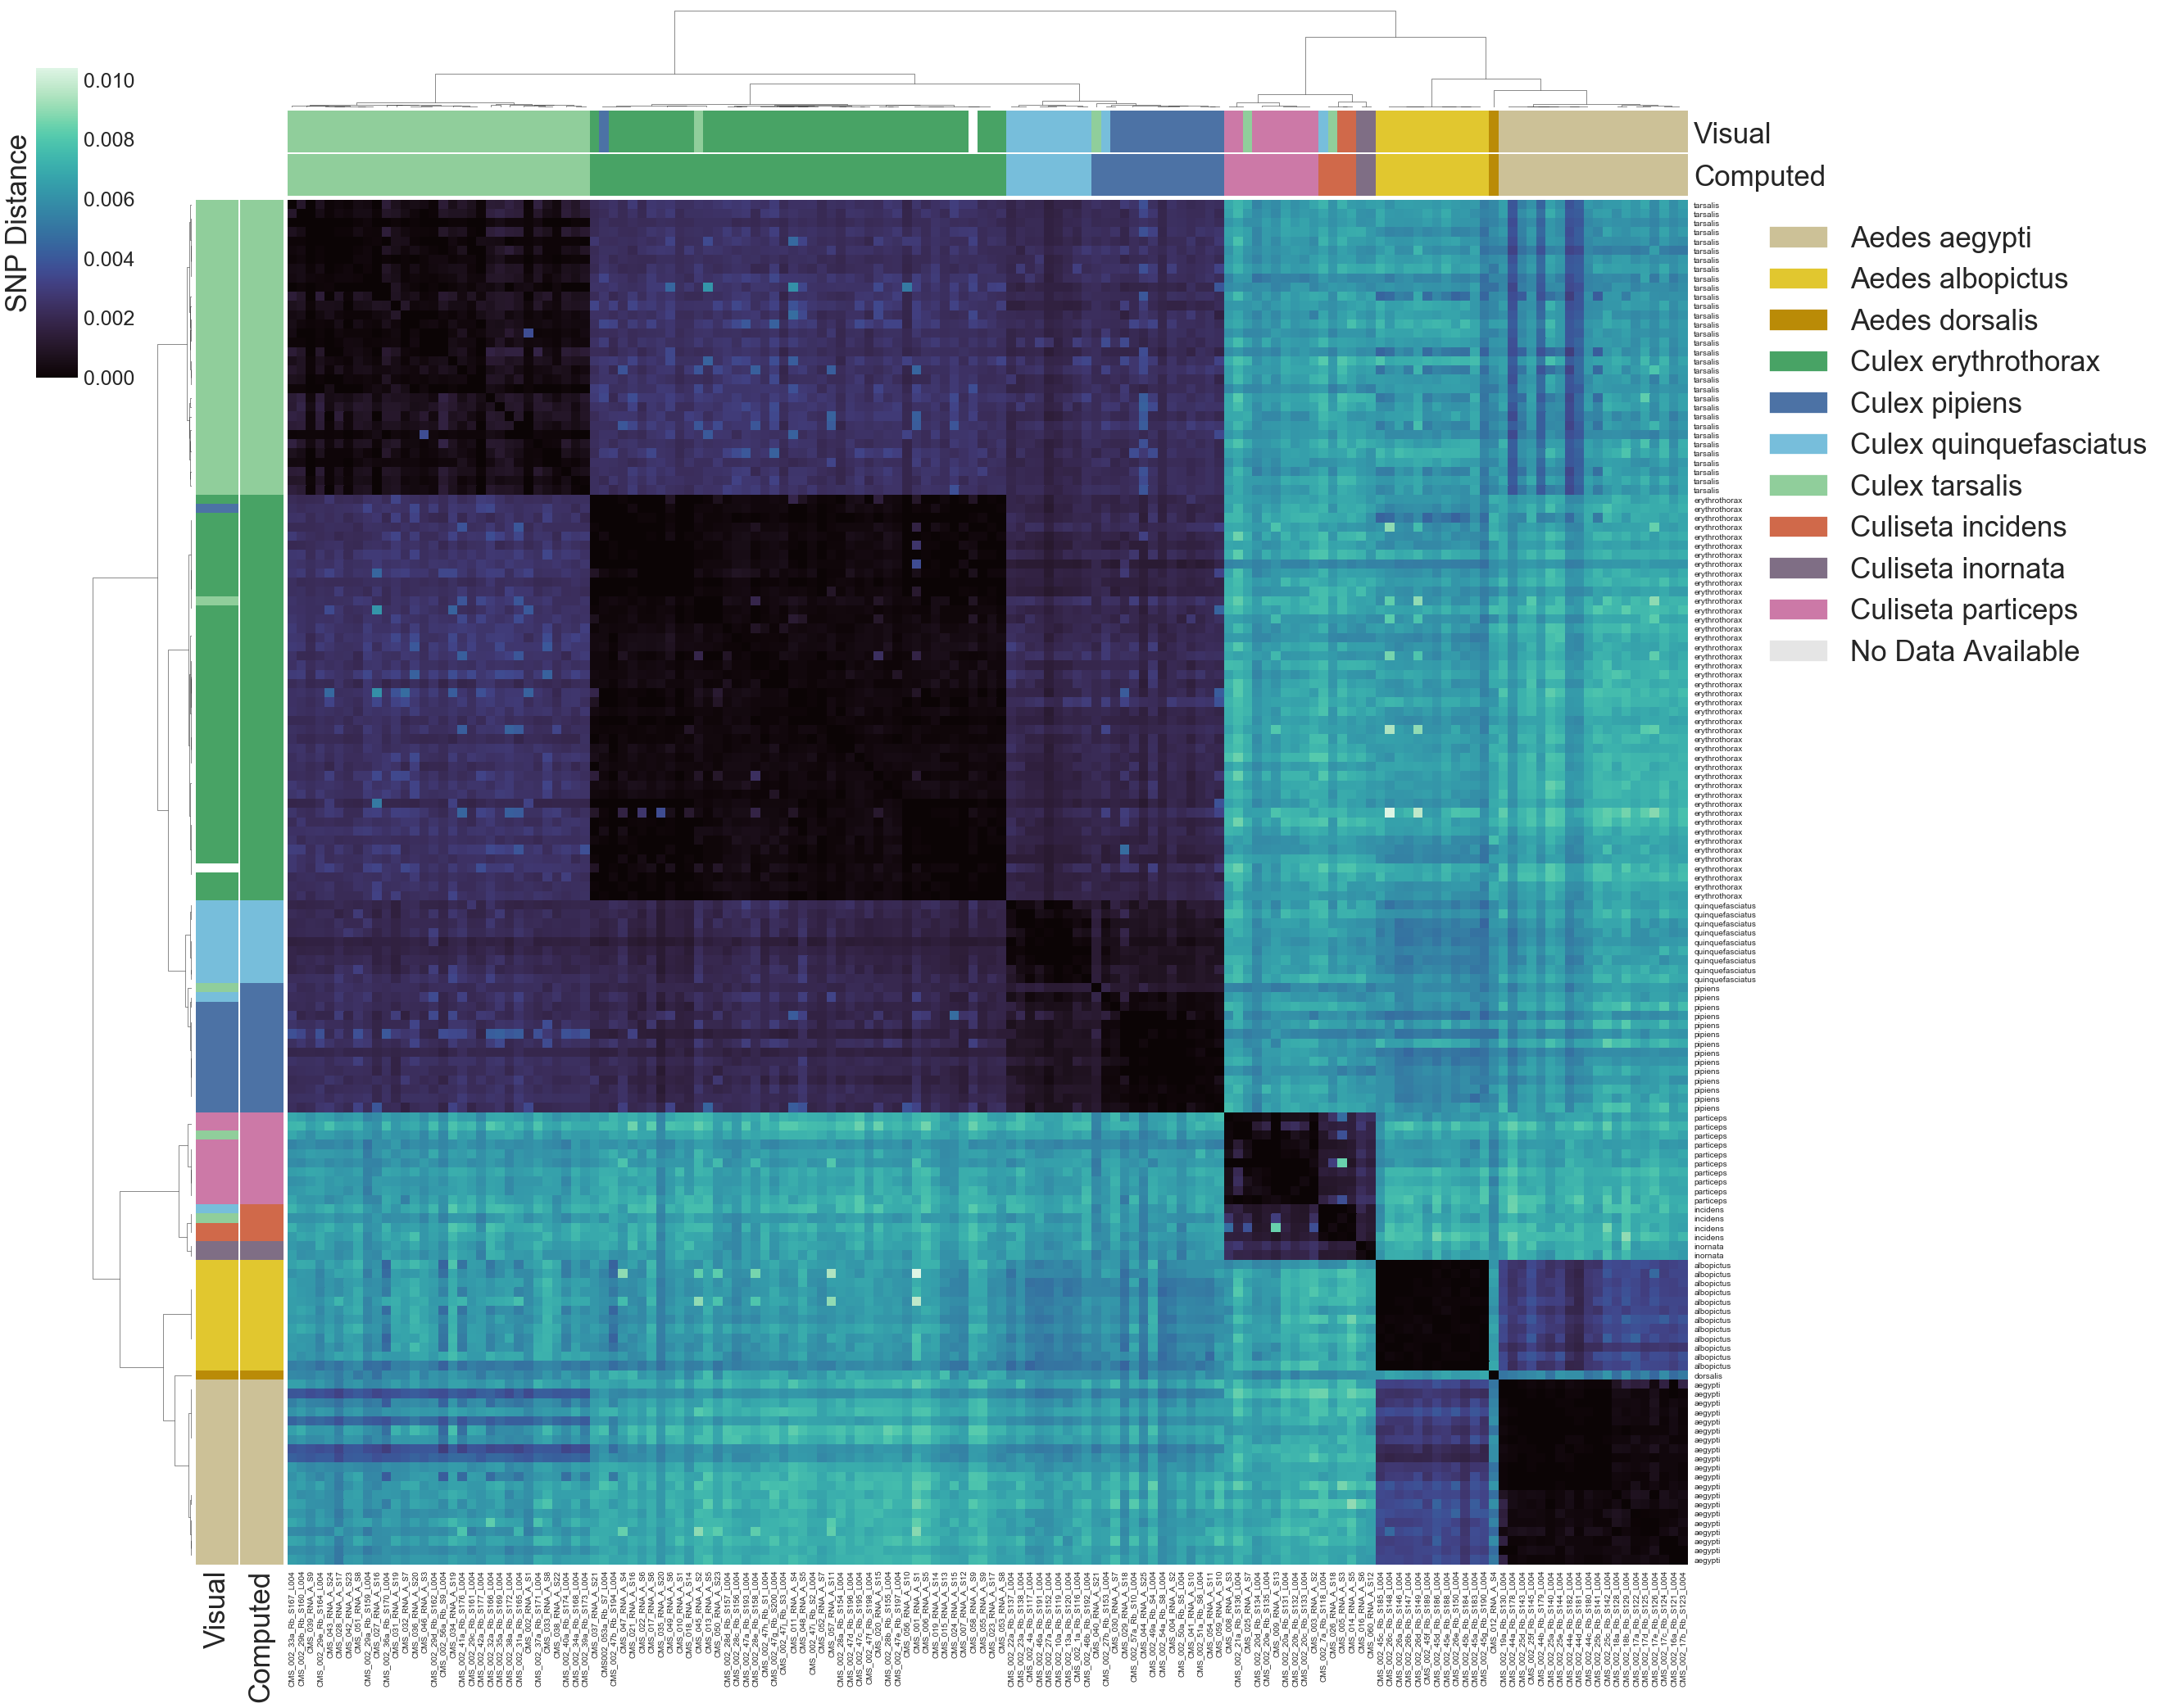

In [6]:
# %%pycodestyle

c, leg, cbar, final_pivot_w_labels = wrap_clustermap_and_mismatches(
    t_raw,
    species_id,
    '_ksize_15',
    k=10,
    figsize=(35,35),
    values="SNP_distance",
    diagonal=0
)

final_pivot_w_labels.query(
    'visual_species != ska_species'
)

Legend: Species relabeling by hierarchical clustering. Heatmap shows pairwise SNP distances between samples estimated using SKA, ranging from 0 (no SNPs detected, black) to 0.01 (1% of comparable sites had SNPs, blue). Outside colorbar indicates visual species label for each sample (Original), inside colorbar indicates consensus visual label for each sample's cluster (Corrected). Each sample was relabeled using it's cluster's consensus.

Text: Species relabeling was performed by clustering samples into genetically similar groups using SNP distances estimated from RNA-seq, and replacing the label for each sample with the most common label in its cluster. Hierarchical clustering based on the Ward distance was used (ref sklearn), and the number of clusters were chosen based on the number of distinct species present (n=10). SNP distances were calculated with SKA using a kmer-sized window of 15 (need reference here), run with nextflow (need reference here) on 100,000 reads subsampled from each mosquito's fastq file using seqtk (need reference here). This resulted in 8 samples having their species corrected.

In [7]:
c.savefig(
    "clustermap_species_assignment_clustermap.svg",
    format="svg",
    bbox_inches='tight'
)

c.savefig(
    "clustermap_species_assignment_clustermap.png",
    format="png",
    bbox_inches='tight'
)

In [8]:
# %%pycodestyle

final_table = final_pivot_w_labels.reset_index()[
    [
        "Sample_1",
        "visual_genus",
        "visual_species",
        "ska_genus",
        "ska_species"
    ]
].rename(
    columns={
        "Sample_1": "Sample Name",
        "visual_species": "Visual Species",
        "visual_genus": "Visual Genus",
        "ska_genus": "Corrected Genus",
        "ska_species": "Corrected Species"
    }
)

final_table.to_csv("visual_vs_corrected_species.csv", index=False)

final_pivot_w_labels.query(
    'visual_species != ska_species'
)

,,,,,CMS002_053a_Rb_S7_L004,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,CMS_002_17c_Rb_S124_L004,CMS_002_17d_Rb_S125_L004,CMS_002_17e_Rb_S126_L004,...,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10,CMS_060_RNA_A_S12
Sample_1,visual_genus,visual_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS002_053a_Rb_S7_L004,Culex,pipiens,Culex,erythrothorax,0.000000,0.000196,0.001703,0.001656,0.006803,0.006993,0.007157,0.007046,0.007164,0.006995,...,0.002589,0.000000,0.000120,0.002081,0.000000,0.000000,0.000118,0.000000,0.002072,0.006644
CMS_002_27b_Rb_S153_L004,Culex,quinquefasciatus,Culex,pipiens,0.002093,0.003095,0.000204,0.000407,0.006417,0.006431,0.006743,0.006680,0.006132,0.006680,...,0.002444,0.001779,0.001892,0.000281,0.001894,0.001622,0.003295,0.002487,0.000456,0.006027
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culiseta,incidens,0.007397,0.007382,0.006635,0.007339,0.006987,0.007747,0.007251,0.007909,0.007351,0.006858,...,0.007307,0.006660,0.006268,0.006553,0.007454,0.006927,0.006645,0.008153,0.006965,0.001193
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,0.006456,0.006506,0.006668,0.006927,0.007124,0.006571,0.006676,0.007206,0.006394,0.006822,...,0.006521,0.007105,0.006205,0.006219,0.007060,0.006616,0.006643,0.007341,0.006294,0.001839
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,0.006088,0.007179,0.005842,0.006129,0.006725,0.006912,0.006747,0.007181,0.007133,0.007186,...,0.006335,0.006193,0.006130,0.005832,0.006331,0.006283,0.006480,0.007073,0.006649,0.001227
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,pipiens,0.001785,0.001924,0.001294,0.001276,0.006369,0.006313,0.006213,0.006607,0.006405,0.006600,...,0.002311,0.001993,0.001779,0.001099,0.001800,0.001638,0.001809,0.001732,0.001243,0.005288
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,0.000222,0.000399,0.002248,0.002321,0.007331,0.007578,0.007287,0.007158,0.007349,0.008949,...,0.002869,0.000368,0.000000,0.002240,0.000126,0.000250,0.000353,0.000867,0.002364,0.006753
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,0.000000,0.000528,0.001679,0.002025,0.006877,0.007182,0.007557,0.007459,0.007599,0.006926,...,0.002230,0.000114,0.000000,0.002041,0.000238,0.000000,0.000343,0.000000,0.002843,0.007224


/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

silhouette score:  SNP Distance 0.8156907760583931 Mash-like Distance 0.2857900389348125


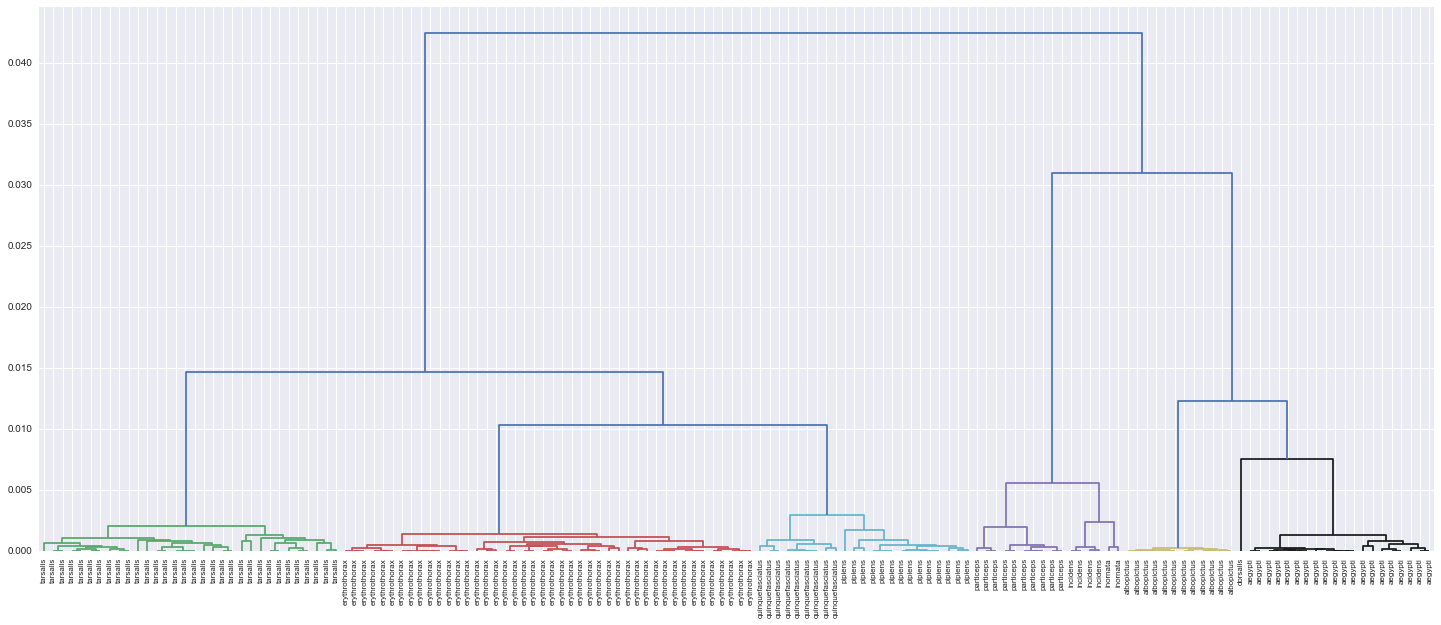

In [9]:
# %%pycodestyle
# Silhouette scores comparing clustering with mash-like distance and snp distance

silhouette_snp = get_silhouette_score(
    t_raw,
    species_id,
    "_ksize_15",
    10,
    values="SNP_distance",
    diagonal=0
    
)

silhouette_mash = get_silhouette_score(
    t_raw,
    species_id,
    "_ksize_15",
    10,
    values="Mash-like_distance",
    diagonal=0
)

print(
    "silhouette score: ",
    f"SNP Distance {silhouette_snp}",
    f"Mash-like Distance {silhouette_mash}"
)

dn = hierarchical_clustering(
    t_raw,
    species_id,
    "_ksize_15",
    10,
    values="SNP_distance",
    diagonal=0
)